### TFG - Cesar Hernandez Rodriguez
Quintos pasos en las redes neuronales y la bolsa, para este caso buscamos predecir valores de cierre de diferentes activos. Este script es una ema de lo que se busca en el TFG, tiene limitacion de activos de los cuales todos se predicen de una forma correcta con minimo 200 epocas.

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['IIIN', 'PRGX', 'UNFI', 'EBIO', 'MINI', 'SNCR', 'USAP', 'JMBA', 'NTLS', 'FDML', 'PTIE']$ de los cuales $NTLS$ no cumple la condicion de que tenga datos para el test en las fechas deseadas y $FDML$ tiene pocos datos para el conjunto test

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

Using TensorFlow backend.


In [2]:
# Tengo dos .csv con todos los tickers que me guarda la API de Quandl y en otro con los tickers que quiero usar
# para esta demo, comparo si estan todos y los pongo en formato de descarga (WIKI/ticker)
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-funciona.csv')['Symbol']
    
    tickersQuandl = []    
    tickers = []
    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq[i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers.append(word)
    
    for tick in tickers:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

# a,b = get_tickers_sample_nasdaq()

In [177]:
# Descargo los datos de la API Quandl, para ello uso el conjunto de datos que me ofrece WIKI/ que se puede ver
# en la página de la libreria y me registro en la pagina de forma gratuita dandome una key.
# me devuelve una lista con todos los datos posibles de ese activo, yo guardo todos y por separado los de cierre
# Aunque solo me interese los de cierre quiero guardar todos los datos por si en una extension de este trabajo se queire 
# usar cualquier otro dato
# Para no tener que realizar la parte de descarga cada vez que se inicia el programa se ha habilitado la descarga
# y guardado de datos en una carpeta datos que ya debe crearse antes. Los datos se guardan serializados.

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2010-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-10-30",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Solo cogemos los datos que nos da la aplicacion
    # ya que hay activos que no tenemos su valor en esas fechas o tenemos muy pocos datos

    quitar = []
    for key in tickers:
        if datosClose_test[key].empty:
            if verbose == True : print("Restriccion de vacio",key) 
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
        elif len(datosClose_test[key]) < 300:
            if verbose == True :  print("Restriccion de longitud",key)
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
            
    for key in quitar:
        tickers.remove(key)
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_test.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_test.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [171]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_test.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_test.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre].plot(figsize=(12,5),grid=True)
    plt.title('{} {}\n'.format(nombre,test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [178]:
datos_descargados = False
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  18.181818181818183 % de los datos
LLeva descargados el  36.36363636363637 % de los datos
LLeva descargados el  54.54545454545454 % de los datos
LLeva descargados el  72.72727272727273 % de los datos
LLeva descargados el  90.9090909090909 % de los datos

Ha tardado en descargar los datos: 18.8511612415 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  18.181818181818183 % de los datos test
LLeva descargados el  36.36363636363637 % de los datos test
LLeva descargados el  54.54545454545454 % de los datos test
LLeva descargados el  72.72727272727273 % de los datos test
LLeva descargados el  90.9090909090909 % de los datos test

Ha tardado en descargar los datos test: 8.0227820873 segundos.


Restriccion de vacio NTLS
Restriccion de longitud FDML


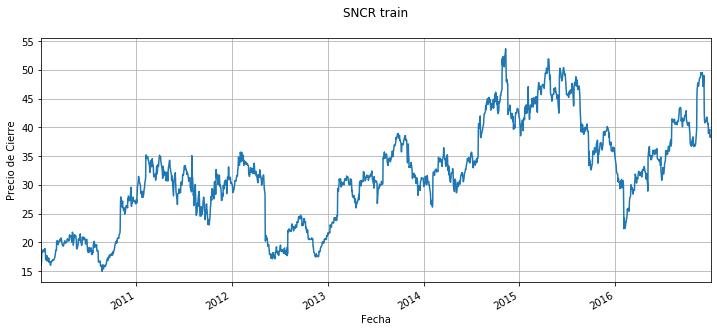

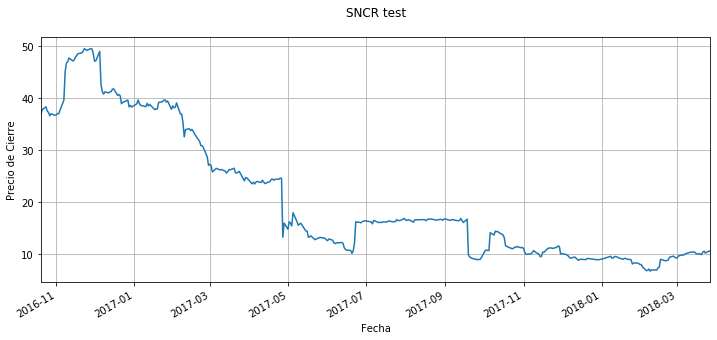

In [173]:
# Grafico un activo aleatorio que luego predecire
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = random.randint(0,len(tickers)-1)
plot_datos(datosClose,tickers[ran],"train")
plot_datos(datosClose_test,tickers[ran],"test")

In [157]:
# Para crear los atributos que voy a meter en la red Neuronal uso esta funcion, mis atributos son
# Dos medias moviles, una de 30 dias y otra de 15 para hacer la simulacion con los datos de un mes y la mitad de mes
# por ulitmo creo un oscilador de la media movil de 30 dias donde resto los valores son separacion de 30 dias
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

    


In [179]:
# A parte de la creacion de atributos
index = ran
timeStep = 21 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers[index]],10,20)
Y = pd.DataFrame(datosClose[tickers[index]].values[21:len(datosClose[tickers[index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers[index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers[index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers[index]].values[21:len(datosClose_test[tickers[index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo ",ticket_uso)

Voy a predecir el activo  SNCR


In [181]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [182]:
# Creacion de la red neural LSTM

model = Sequential()
model.add(LSTM(4, input_shape=(21,3),return_sequences=True))
model.add(LSTM(units = 2,return_sequences = False))
model.add(Dense(1)) 
model.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 21, 4)             128       
_________________________________________________________________
lstm_16 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [183]:
history_LSTM = model.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Train on 1146 samples, validate on 574 samples
Epoch 1/1500
1146/1146 [==============================] - 3s 2ms/step - loss: 1105.2145 - porcentaje_margen: 0.0000e+00 - val_loss: 1068.2806 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1146/1146 [==============================] - 1s 963us/step - loss: 1078.3657 - porcentaje_margen: 0.0000e+00 - val_loss: 1036.8750 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 1043.0886 - porcentaje_margen: 0.0000e+00 - val_loss: 1003.2939 - val_porcentaje_margen: 0.0000e+00
Epoch 4/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 1016.3349 - porcentaje_margen: 0.0000e+00 - val_loss: 982.1887 - val_porcentaje_margen: 0.0000e+00
Epoch 5/1500
1146/1146 [==============================] - 1s 996us/step - loss: 996.9557 - porcentaje_margen: 0.0000e+00 - val_loss: 964.6081 - val_porcentaje_margen: 0.0000e+00
Epoch 6/1500
1146/1146 [==============================] - 1s 9

1146/1146 [==============================] - 1s 870us/step - loss: 703.5091 - porcentaje_margen: 0.0000e+00 - val_loss: 680.7409 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
1146/1146 [==============================] - 1s 885us/step - loss: 698.3050 - porcentaje_margen: 0.0000e+00 - val_loss: 675.6600 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
1146/1146 [==============================] - 1s 868us/step - loss: 693.1526 - porcentaje_margen: 0.0000e+00 - val_loss: 670.5643 - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
1146/1146 [==============================] - 1s 884us/step - loss: 688.0224 - porcentaje_margen: 0.0000e+00 - val_loss: 665.5109 - val_porcentaje_margen: 0.0000e+00
Epoch 50/1500
1146/1146 [==============================] - 1s 871us/step - loss: 682.9274 - porcentaje_margen: 0.0000e+00 - val_loss: 660.4952 - val_porcentaje_margen: 0.0000e+00
Epoch 51/1500
1146/1146 [==============================] - 1s 890us/step - loss: 677.8653 - porcentaje_margen: 0.0000e+

Epoch 92/1500
1146/1146 [==============================] - 1s 819us/step - loss: 494.2329 - porcentaje_margen: 0.0000e+00 - val_loss: 475.0293 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
1146/1146 [==============================] - 1s 904us/step - loss: 490.2675 - porcentaje_margen: 0.0000e+00 - val_loss: 471.1699 - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
1146/1146 [==============================] - 1s 887us/step - loss: 486.3445 - porcentaje_margen: 0.0000e+00 - val_loss: 467.3017 - val_porcentaje_margen: 0.0000e+00
Epoch 95/1500
1146/1146 [==============================] - 1s 931us/step - loss: 482.4295 - porcentaje_margen: 0.0000e+00 - val_loss: 463.4748 - val_porcentaje_margen: 0.0000e+00
Epoch 96/1500
1146/1146 [==============================] - 1s 906us/step - loss: 478.5489 - porcentaje_margen: 0.0000e+00 - val_loss: 459.6536 - val_porcentaje_margen: 0.0000e+00
Epoch 97/1500
1146/1146 [==============================] - 1s 989us/step - loss: 474.6840 - porcentaje_ma

1146/1146 [==============================] - 1s 1ms/step - loss: 334.8130 - porcentaje_margen: 0.0122 - val_loss: 318.9357 - val_porcentaje_margen: 0.0139
Epoch 139/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 331.8436 - porcentaje_margen: 0.0122 - val_loss: 316.0208 - val_porcentaje_margen: 0.0122
Epoch 140/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 328.8814 - porcentaje_margen: 0.0132 - val_loss: 313.1409 - val_porcentaje_margen: 0.0104
Epoch 141/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 325.9495 - porcentaje_margen: 0.0167 - val_loss: 310.2563 - val_porcentaje_margen: 0.0104
Epoch 142/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 323.0297 - porcentaje_margen: 0.0176 - val_loss: 307.4107 - val_porcentaje_margen: 0.0122
Epoch 143/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 320.1342 - porcentaje_margen: 0.0204 - val_loss: 304.5918 - val_porcentaje_margen: 0.

1146/1146 [==============================] - 1s 978us/step - loss: 213.8430 - porcentaje_margen: 0.0751 - val_loss: 201.2183 - val_porcentaje_margen: 0.0749
Epoch 187/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 211.7935 - porcentaje_margen: 0.0729 - val_loss: 199.2060 - val_porcentaje_margen: 0.0714
Epoch 188/1500
1146/1146 [==============================] - 1s 898us/step - loss: 209.7449 - porcentaje_margen: 0.0742 - val_loss: 197.2375 - val_porcentaje_margen: 0.0714
Epoch 189/1500
1146/1146 [==============================] - 1s 960us/step - loss: 207.7245 - porcentaje_margen: 0.0726 - val_loss: 195.2744 - val_porcentaje_margen: 0.0645
Epoch 190/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 205.7217 - porcentaje_margen: 0.0724 - val_loss: 193.3248 - val_porcentaje_margen: 0.0627
Epoch 191/1500
1146/1146 [==============================] - 1s 998us/step - loss: 203.7338 - porcentaje_margen: 0.0714 - val_loss: 191.4021 - val_porcentaje_ma

Epoch 234/1500
1146/1146 [==============================] - 1s 896us/step - loss: 134.7910 - porcentaje_margen: 0.0410 - val_loss: 125.1420 - val_porcentaje_margen: 0.0280
Epoch 235/1500
1146/1146 [==============================] - 1s 899us/step - loss: 133.5523 - porcentaje_margen: 0.0408 - val_loss: 123.9801 - val_porcentaje_margen: 0.0297
Epoch 236/1500
1146/1146 [==============================] - 1s 921us/step - loss: 132.3373 - porcentaje_margen: 0.0419 - val_loss: 122.8080 - val_porcentaje_margen: 0.0297
Epoch 237/1500
1146/1146 [==============================] - 1s 894us/step - loss: 131.1353 - porcentaje_margen: 0.0412 - val_loss: 121.6501 - val_porcentaje_margen: 0.0297
Epoch 238/1500
1146/1146 [==============================] - 1s 981us/step - loss: 129.9376 - porcentaje_margen: 0.0403 - val_loss: 120.5451 - val_porcentaje_margen: 0.0297
Epoch 239/1500
1146/1146 [==============================] - 1s 962us/step - loss: 128.7693 - porcentaje_margen: 0.0401 - val_loss: 119.4401 

Epoch 282/1500
1146/1146 [==============================] - 1s 894us/step - loss: 92.1981 - porcentaje_margen: 0.0813 - val_loss: 85.1906 - val_porcentaje_margen: 0.0973
Epoch 283/1500
1146/1146 [==============================] - 1s 923us/step - loss: 91.6454 - porcentaje_margen: 0.0824 - val_loss: 84.6753 - val_porcentaje_margen: 0.1027
Epoch 284/1500
1146/1146 [==============================] - 1s 935us/step - loss: 91.0972 - porcentaje_margen: 0.0850 - val_loss: 84.1846 - val_porcentaje_margen: 0.0975
Epoch 285/1500
1146/1146 [==============================] - 1s 919us/step - loss: 90.5684 - porcentaje_margen: 0.0883 - val_loss: 83.6940 - val_porcentaje_margen: 0.0957
Epoch 286/1500
1146/1146 [==============================] - 1s 920us/step - loss: 90.0449 - porcentaje_margen: 0.0898 - val_loss: 83.2295 - val_porcentaje_margen: 0.0957
Epoch 287/1500
1146/1146 [==============================] - 1s 899us/step - loss: 89.5415 - porcentaje_margen: 0.0907 - val_loss: 82.7610 - val_porcen

1146/1146 [==============================] - 1s 870us/step - loss: 76.8762 - porcentaje_margen: 0.2198 - val_loss: 71.7769 - val_porcentaje_margen: 0.2197
Epoch 331/1500
1146/1146 [==============================] - 1s 957us/step - loss: 76.7468 - porcentaje_margen: 0.2223 - val_loss: 71.6859 - val_porcentaje_margen: 0.2179
Epoch 332/1500
1146/1146 [==============================] - 1s 932us/step - loss: 76.6293 - porcentaje_margen: 0.2242 - val_loss: 71.5872 - val_porcentaje_margen: 0.2214
Epoch 333/1500
1146/1146 [==============================] - 1s 912us/step - loss: 76.5085 - porcentaje_margen: 0.2232 - val_loss: 71.5053 - val_porcentaje_margen: 0.2249
Epoch 334/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 76.4016 - porcentaje_margen: 0.2215 - val_loss: 71.4181 - val_porcentaje_margen: 0.2266
Epoch 335/1500
1146/1146 [==============================] - 1s 922us/step - loss: 76.2934 - porcentaje_margen: 0.2200 - val_loss: 71.3419 - val_porcentaje_margen: 0.23

1146/1146 [==============================] - 1s 1ms/step - loss: 37.0799 - porcentaje_margen: 0.4011 - val_loss: 34.0342 - val_porcentaje_margen: 0.4183
Epoch 379/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 36.2692 - porcentaje_margen: 0.4183 - val_loss: 33.3857 - val_porcentaje_margen: 0.4008
Epoch 380/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 35.5582 - porcentaje_margen: 0.4109 - val_loss: 32.7477 - val_porcentaje_margen: 0.4130
Epoch 381/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 35.2212 - porcentaje_margen: 0.3969 - val_loss: 31.9866 - val_porcentaje_margen: 0.4199
Epoch 382/1500
1146/1146 [==============================] - 1s 908us/step - loss: 34.2205 - porcentaje_margen: 0.4102 - val_loss: 31.3530 - val_porcentaje_margen: 0.4461
Epoch 383/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 33.4828 - porcentaje_margen: 0.4221 - val_loss: 30.8172 - val_porcentaje_margen: 0.4094
Epoch

Epoch 427/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 16.1028 - porcentaje_margen: 0.5246 - val_loss: 14.9634 - val_porcentaje_margen: 0.5556
Epoch 428/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 15.8628 - porcentaje_margen: 0.5302 - val_loss: 14.6973 - val_porcentaje_margen: 0.5486
Epoch 429/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 15.6221 - porcentaje_margen: 0.5323 - val_loss: 14.4909 - val_porcentaje_margen: 0.5521
Epoch 430/1500
1146/1146 [==============================] - 1s 979us/step - loss: 15.4670 - porcentaje_margen: 0.5202 - val_loss: 14.3579 - val_porcentaje_margen: 0.5294
Epoch 431/1500
1146/1146 [==============================] - 1s 965us/step - loss: 15.1486 - porcentaje_margen: 0.5273 - val_loss: 14.1266 - val_porcentaje_margen: 0.5398
Epoch 432/1500
1146/1146 [==============================] - ETA: 0s - loss: 15.1215 - porcentaje_margen: 0.53 - 1s 1ms/step - loss: 14.9417 - porcentaje_mar

1146/1146 [==============================] - 1s 987us/step - loss: 8.0040 - porcentaje_margen: 0.6106 - val_loss: 7.8745 - val_porcentaje_margen: 0.5853
Epoch 476/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 7.8971 - porcentaje_margen: 0.6051 - val_loss: 7.5689 - val_porcentaje_margen: 0.5990
Epoch 477/1500
1146/1146 [==============================] - 1s 964us/step - loss: 7.7702 - porcentaje_margen: 0.6086 - val_loss: 7.4196 - val_porcentaje_margen: 0.6269
Epoch 478/1500
1146/1146 [==============================] - 1s 962us/step - loss: 7.6640 - porcentaje_margen: 0.6100 - val_loss: 7.3813 - val_porcentaje_margen: 0.6216
Epoch 479/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 7.5887 - porcentaje_margen: 0.6229 - val_loss: 7.4367 - val_porcentaje_margen: 0.5904
Epoch 480/1500
1146/1146 [==============================] - 1s 996us/step - loss: 7.4757 - porcentaje_margen: 0.6213 - val_loss: 7.2750 - val_porcentaje_margen: 0.6044
Epoch 481/1

Epoch 524/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.5968 - porcentaje_margen: 0.6698 - val_loss: 4.6210 - val_porcentaje_margen: 0.6446
Epoch 525/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.5926 - porcentaje_margen: 0.6627 - val_loss: 4.4707 - val_porcentaje_margen: 0.6668
Epoch 526/1500
1146/1146 [==============================] - 1s 970us/step - loss: 4.5945 - porcentaje_margen: 0.6656 - val_loss: 4.4475 - val_porcentaje_margen: 0.6841
Epoch 527/1500
1146/1146 [==============================] - 1s 932us/step - loss: 4.6095 - porcentaje_margen: 0.6531 - val_loss: 4.4370 - val_porcentaje_margen: 0.6565
Epoch 528/1500
1146/1146 [==============================] - 1s 934us/step - loss: 4.4711 - porcentaje_margen: 0.6683 - val_loss: 4.3782 - val_porcentaje_margen: 0.6792
Epoch 529/1500
1146/1146 [==============================] - 1s 966us/step - loss: 4.4283 - porcentaje_margen: 0.6690 - val_loss: 4.3317 - val_porcentaje_margen: 0.6

Epoch 573/1500
1146/1146 [==============================] - 1s 958us/step - loss: 3.5318 - porcentaje_margen: 0.6919 - val_loss: 3.5221 - val_porcentaje_margen: 0.6987
Epoch 574/1500
1146/1146 [==============================] - 1s 993us/step - loss: 3.5057 - porcentaje_margen: 0.7050 - val_loss: 3.5968 - val_porcentaje_margen: 0.6689
Epoch 575/1500
1146/1146 [==============================] - 1s 900us/step - loss: 3.4902 - porcentaje_margen: 0.6909 - val_loss: 3.4987 - val_porcentaje_margen: 0.6865
Epoch 576/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 3.4322 - porcentaje_margen: 0.7017 - val_loss: 3.4057 - val_porcentaje_margen: 0.7106
Epoch 577/1500
1146/1146 [==============================] - 1s 927us/step - loss: 3.4132 - porcentaje_margen: 0.7141 - val_loss: 3.4075 - val_porcentaje_margen: 0.7037
Epoch 578/1500
1146/1146 [==============================] - 1s 934us/step - loss: 3.3931 - porcentaje_margen: 0.7156 - val_loss: 3.4366 - val_porcentaje_margen: 0

1146/1146 [==============================] - 1s 1ms/step - loss: 3.1344 - porcentaje_margen: 0.7185 - val_loss: 3.2649 - val_porcentaje_margen: 0.6897
Epoch 623/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 3.0881 - porcentaje_margen: 0.7254 - val_loss: 3.0693 - val_porcentaje_margen: 0.7296
Epoch 624/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 3.0534 - porcentaje_margen: 0.7327 - val_loss: 3.1337 - val_porcentaje_margen: 0.7178
Epoch 625/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 3.1091 - porcentaje_margen: 0.7121 - val_loss: 3.0478 - val_porcentaje_margen: 0.7314
Epoch 626/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 3.0234 - porcentaje_margen: 0.7312 - val_loss: 3.0968 - val_porcentaje_margen: 0.7248
Epoch 627/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 3.0535 - porcentaje_margen: 0.7298 - val_loss: 3.1311 - val_porcentaje_margen: 0.7350
Epoch 628/1500
1146

1146/1146 [==============================] - 1s 1ms/step - loss: 2.8721 - porcentaje_margen: 0.7308 - val_loss: 3.0053 - val_porcentaje_margen: 0.7212
Epoch 672/1500
1146/1146 [==============================] - 1s 976us/step - loss: 2.9149 - porcentaje_margen: 0.7228 - val_loss: 2.9258 - val_porcentaje_margen: 0.7472
Epoch 673/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.8816 - porcentaje_margen: 0.7352 - val_loss: 2.9273 - val_porcentaje_margen: 0.7370
Epoch 674/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.8472 - porcentaje_margen: 0.7477 - val_loss: 2.9720 - val_porcentaje_margen: 0.7435
Epoch 675/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.8462 - porcentaje_margen: 0.7461 - val_loss: 3.0714 - val_porcentaje_margen: 0.7399
Epoch 676/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.9228 - porcentaje_margen: 0.7402 - val_loss: 2.9802 - val_porcentaje_margen: 0.7453
Epoch 677/1500
11

1146/1146 [==============================] - 1s 1ms/step - loss: 2.7024 - porcentaje_margen: 0.7465 - val_loss: 2.8477 - val_porcentaje_margen: 0.7524
Epoch 721/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.6880 - porcentaje_margen: 0.7545 - val_loss: 2.8946 - val_porcentaje_margen: 0.7473
Epoch 722/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.7376 - porcentaje_margen: 0.7417 - val_loss: 2.8609 - val_porcentaje_margen: 0.7508
Epoch 723/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.6944 - porcentaje_margen: 0.7553 - val_loss: 2.8914 - val_porcentaje_margen: 0.7353
Epoch 724/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.7267 - porcentaje_margen: 0.7482 - val_loss: 3.0687 - val_porcentaje_margen: 0.6984
Epoch 725/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.7566 - porcentaje_margen: 0.7414 - val_loss: 2.8734 - val_porcentaje_margen: 0.7440
Epoch 726/1500
1146

1146/1146 [==============================] - 1s 1ms/step - loss: 2.6715 - porcentaje_margen: 0.7390 - val_loss: 2.7967 - val_porcentaje_margen: 0.7455
Epoch 770/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.6263 - porcentaje_margen: 0.7453 - val_loss: 2.8513 - val_porcentaje_margen: 0.7437
Epoch 771/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.6230 - porcentaje_margen: 0.7505 - val_loss: 2.8263 - val_porcentaje_margen: 0.7420
Epoch 772/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.6200 - porcentaje_margen: 0.7610 - val_loss: 2.8000 - val_porcentaje_margen: 0.7455
Epoch 773/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.5921 - porcentaje_margen: 0.7547 - val_loss: 2.7989 - val_porcentaje_margen: 0.7369
Epoch 774/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.6254 - porcentaje_margen: 0.7432 - val_loss: 2.8138 - val_porcentaje_margen: 0.7435
Epoch 775/1500
1146

1146/1146 [==============================] - 1s 1ms/step - loss: 2.4946 - porcentaje_margen: 0.7692 - val_loss: 2.7225 - val_porcentaje_margen: 0.7506
Epoch 819/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.4949 - porcentaje_margen: 0.7640 - val_loss: 2.7493 - val_porcentaje_margen: 0.7541
Epoch 820/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.5704 - porcentaje_margen: 0.7445 - val_loss: 2.7664 - val_porcentaje_margen: 0.7487
Epoch 821/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.5600 - porcentaje_margen: 0.7514 - val_loss: 2.7156 - val_porcentaje_margen: 0.7523
Epoch 822/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.5337 - porcentaje_margen: 0.7547 - val_loss: 2.7816 - val_porcentaje_margen: 0.7490
Epoch 823/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.4987 - porcentaje_margen: 0.7618 - val_loss: 2.7514 - val_porcentaje_margen: 0.7541
Epoch 824/1500
1146

1146/1146 [==============================] - 1s 1ms/step - loss: 2.4603 - porcentaje_margen: 0.7555 - val_loss: 2.7032 - val_porcentaje_margen: 0.7612
Epoch 868/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.4248 - porcentaje_margen: 0.7653 - val_loss: 2.6789 - val_porcentaje_margen: 0.7522
Epoch 869/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.4804 - porcentaje_margen: 0.7517 - val_loss: 2.8240 - val_porcentaje_margen: 0.7264
Epoch 870/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.4169 - porcentaje_margen: 0.7657 - val_loss: 2.7602 - val_porcentaje_margen: 0.7541
Epoch 871/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.5387 - porcentaje_margen: 0.7559 - val_loss: 2.7229 - val_porcentaje_margen: 0.7542
Epoch 872/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.4851 - porcentaje_margen: 0.7583 - val_loss: 2.6974 - val_porcentaje_margen: 0.7611
Epoch 873/1500
1146

1146/1146 [==============================] - 1s 1ms/step - loss: 2.3959 - porcentaje_margen: 0.7768 - val_loss: 2.6585 - val_porcentaje_margen: 0.7507
Epoch 917/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3895 - porcentaje_margen: 0.7692 - val_loss: 2.7174 - val_porcentaje_margen: 0.7387
Epoch 918/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3648 - porcentaje_margen: 0.7714 - val_loss: 2.6406 - val_porcentaje_margen: 0.7490
Epoch 919/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3935 - porcentaje_margen: 0.7590 - val_loss: 2.6308 - val_porcentaje_margen: 0.7663
Epoch 920/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3626 - porcentaje_margen: 0.7655 - val_loss: 2.6580 - val_porcentaje_margen: 0.7630
Epoch 921/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3967 - porcentaje_margen: 0.7629 - val_loss: 2.6659 - val_porcentaje_margen: 0.7420
Epoch 922/1500
1146

1146/1146 [==============================] - 1s 1ms/step - loss: 2.4067 - porcentaje_margen: 0.7718 - val_loss: 2.6297 - val_porcentaje_margen: 0.7436
Epoch 966/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3757 - porcentaje_margen: 0.7657 - val_loss: 2.6914 - val_porcentaje_margen: 0.7611
Epoch 967/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3985 - porcentaje_margen: 0.7699 - val_loss: 2.7555 - val_porcentaje_margen: 0.7333
Epoch 968/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3543 - porcentaje_margen: 0.7763 - val_loss: 2.6150 - val_porcentaje_margen: 0.7698
Epoch 969/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.4090 - porcentaje_margen: 0.7629 - val_loss: 2.6498 - val_porcentaje_margen: 0.7403
Epoch 970/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3941 - porcentaje_margen: 0.7603 - val_loss: 2.7691 - val_porcentaje_margen: 0.7508
Epoch 971/1500
1146

1146/1146 [==============================] - 1s 1ms/step - loss: 2.3704 - porcentaje_margen: 0.7738 - val_loss: 2.6433 - val_porcentaje_margen: 0.7543
Epoch 1015/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3510 - porcentaje_margen: 0.7685 - val_loss: 2.6450 - val_porcentaje_margen: 0.7507
Epoch 1016/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3193 - porcentaje_margen: 0.7728 - val_loss: 2.6085 - val_porcentaje_margen: 0.7541
Epoch 1017/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3398 - porcentaje_margen: 0.7702 - val_loss: 2.6466 - val_porcentaje_margen: 0.7611
Epoch 1018/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3534 - porcentaje_margen: 0.7634 - val_loss: 2.6384 - val_porcentaje_margen: 0.7421
Epoch 1019/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3861 - porcentaje_margen: 0.7657 - val_loss: 2.6883 - val_porcentaje_margen: 0.7403
Epoch 1020/150

1146/1146 [==============================] - 1s 1ms/step - loss: 2.3539 - porcentaje_margen: 0.7536 - val_loss: 2.8060 - val_porcentaje_margen: 0.7247
Epoch 1064/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3712 - porcentaje_margen: 0.7583 - val_loss: 2.7217 - val_porcentaje_margen: 0.7491
Epoch 1065/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3261 - porcentaje_margen: 0.7800 - val_loss: 2.6059 - val_porcentaje_margen: 0.7542
Epoch 1066/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3053 - porcentaje_margen: 0.7686 - val_loss: 2.6226 - val_porcentaje_margen: 0.7542
Epoch 1067/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3118 - porcentaje_margen: 0.7674 - val_loss: 2.5723 - val_porcentaje_margen: 0.7611
Epoch 1068/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3335 - porcentaje_margen: 0.7749 - val_loss: 2.6062 - val_porcentaje_margen: 0.7436
Epoch 1069/150

1146/1146 [==============================] - 1s 1ms/step - loss: 2.3271 - porcentaje_margen: 0.7768 - val_loss: 2.7125 - val_porcentaje_margen: 0.7507
Epoch 1113/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3013 - porcentaje_margen: 0.7756 - val_loss: 2.5958 - val_porcentaje_margen: 0.7611
Epoch 1114/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3202 - porcentaje_margen: 0.7737 - val_loss: 2.5549 - val_porcentaje_margen: 0.7611
Epoch 1115/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2827 - porcentaje_margen: 0.7718 - val_loss: 2.6456 - val_porcentaje_margen: 0.7420
Epoch 1116/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2938 - porcentaje_margen: 0.7595 - val_loss: 2.7241 - val_porcentaje_margen: 0.7698
Epoch 1117/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3502 - porcentaje_margen: 0.7699 - val_loss: 2.6578 - val_porcentaje_margen: 0.7507
Epoch 1118/150

1146/1146 [==============================] - 1s 1ms/step - loss: 2.3090 - porcentaje_margen: 0.7761 - val_loss: 2.5351 - val_porcentaje_margen: 0.7767
Epoch 1162/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2977 - porcentaje_margen: 0.7742 - val_loss: 2.6515 - val_porcentaje_margen: 0.7437
Epoch 1163/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3329 - porcentaje_margen: 0.7763 - val_loss: 2.6302 - val_porcentaje_margen: 0.7542
Epoch 1164/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3231 - porcentaje_margen: 0.7603 - val_loss: 2.6343 - val_porcentaje_margen: 0.7595
Epoch 1165/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2912 - porcentaje_margen: 0.7778 - val_loss: 2.5429 - val_porcentaje_margen: 0.7715
Epoch 1166/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3088 - porcentaje_margen: 0.7740 - val_loss: 2.7510 - val_porcentaje_margen: 0.7524
Epoch 1167/150

1146/1146 [==============================] - 1s 1ms/step - loss: 2.2427 - porcentaje_margen: 0.7841 - val_loss: 2.6004 - val_porcentaje_margen: 0.7578
Epoch 1211/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2865 - porcentaje_margen: 0.7733 - val_loss: 2.5636 - val_porcentaje_margen: 0.7611
Epoch 1212/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3089 - porcentaje_margen: 0.7757 - val_loss: 2.6230 - val_porcentaje_margen: 0.7576
Epoch 1213/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2715 - porcentaje_margen: 0.7800 - val_loss: 2.5436 - val_porcentaje_margen: 0.7750
Epoch 1214/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3618 - porcentaje_margen: 0.7640 - val_loss: 2.6237 - val_porcentaje_margen: 0.7542
Epoch 1215/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2951 - porcentaje_margen: 0.7738 - val_loss: 2.5284 - val_porcentaje_margen: 0.7628
Epoch 1216/150

1146/1146 [==============================] - 1s 1ms/step - loss: 2.2838 - porcentaje_margen: 0.7815 - val_loss: 2.5271 - val_porcentaje_margen: 0.7715
Epoch 1260/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2620 - porcentaje_margen: 0.7763 - val_loss: 2.5478 - val_porcentaje_margen: 0.7646
Epoch 1261/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2665 - porcentaje_margen: 0.7805 - val_loss: 2.6514 - val_porcentaje_margen: 0.7524
Epoch 1262/1500
1146/1146 [==============================] - 1s 972us/step - loss: 2.2624 - porcentaje_margen: 0.7788 - val_loss: 2.5725 - val_porcentaje_margen: 0.7418
Epoch 1263/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2814 - porcentaje_margen: 0.7778 - val_loss: 2.5965 - val_porcentaje_margen: 0.7541
Epoch 1264/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2891 - porcentaje_margen: 0.7694 - val_loss: 2.5890 - val_porcentaje_margen: 0.7558
Epoch 1265/1

1146/1146 [==============================] - 1s 1ms/step - loss: 2.2491 - porcentaje_margen: 0.7716 - val_loss: 2.5570 - val_porcentaje_margen: 0.7698
Epoch 1309/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2375 - porcentaje_margen: 0.7846 - val_loss: 2.5643 - val_porcentaje_margen: 0.7612
Epoch 1310/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2462 - porcentaje_margen: 0.7837 - val_loss: 2.5471 - val_porcentaje_margen: 0.7574
Epoch 1311/1500
1146/1146 [==============================] - 1s 991us/step - loss: 2.2751 - porcentaje_margen: 0.7748 - val_loss: 2.6713 - val_porcentaje_margen: 0.7664
Epoch 1312/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2712 - porcentaje_margen: 0.7813 - val_loss: 2.6116 - val_porcentaje_margen: 0.7314
Epoch 1313/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2525 - porcentaje_margen: 0.7776 - val_loss: 2.6178 - val_porcentaje_margen: 0.7645
Epoch 1314/1

1146/1146 [==============================] - 1s 1ms/step - loss: 2.2329 - porcentaje_margen: 0.7818 - val_loss: 2.5521 - val_porcentaje_margen: 0.7663
Epoch 1358/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2228 - porcentaje_margen: 0.7731 - val_loss: 2.5393 - val_porcentaje_margen: 0.7681
Epoch 1359/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2489 - porcentaje_margen: 0.7776 - val_loss: 2.5714 - val_porcentaje_margen: 0.7751
Epoch 1360/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2471 - porcentaje_margen: 0.7750 - val_loss: 2.5781 - val_porcentaje_margen: 0.7628
Epoch 1361/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2378 - porcentaje_margen: 0.7729 - val_loss: 2.5951 - val_porcentaje_margen: 0.7523
Epoch 1362/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2293 - porcentaje_margen: 0.7863 - val_loss: 2.5750 - val_porcentaje_margen: 0.7628
Epoch 1363/150

1146/1146 [==============================] - 1s 1ms/step - loss: 2.2314 - porcentaje_margen: 0.7850 - val_loss: 2.5799 - val_porcentaje_margen: 0.7559
Epoch 1407/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2248 - porcentaje_margen: 0.7809 - val_loss: 2.5606 - val_porcentaje_margen: 0.7575
Epoch 1408/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2047 - porcentaje_margen: 0.7829 - val_loss: 2.5818 - val_porcentaje_margen: 0.7541
Epoch 1409/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2250 - porcentaje_margen: 0.7748 - val_loss: 2.5825 - val_porcentaje_margen: 0.7733
Epoch 1410/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2788 - porcentaje_margen: 0.7814 - val_loss: 2.5747 - val_porcentaje_margen: 0.7681
Epoch 1411/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2859 - porcentaje_margen: 0.7718 - val_loss: 2.6869 - val_porcentaje_margen: 0.7472
Epoch 1412/150

Epoch 1455/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2530 - porcentaje_margen: 0.7725 - val_loss: 2.5869 - val_porcentaje_margen: 0.7471
Epoch 1456/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2111 - porcentaje_margen: 0.7750 - val_loss: 2.5993 - val_porcentaje_margen: 0.7716
Epoch 1457/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2443 - porcentaje_margen: 0.7848 - val_loss: 2.5504 - val_porcentaje_margen: 0.7646
Epoch 1458/1500
1146/1146 [==============================] - 1s 994us/step - loss: 2.2388 - porcentaje_margen: 0.7857 - val_loss: 2.6130 - val_porcentaje_margen: 0.7610
Epoch 1459/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.3478 - porcentaje_margen: 0.7529 - val_loss: 2.5900 - val_porcentaje_margen: 0.7610
Epoch 1460/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 2.2591 - porcentaje_margen: 0.7658 - val_loss: 2.5298 - val_porcentaje_margen: 0.7

#### Si vemos que necesitamos mas epocas corremos este codigo
history_LSTM = model.fit(X_train,
                  y_train,
                  initial_epoch=700,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

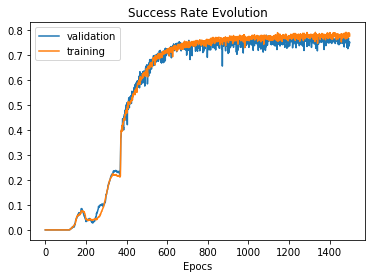

In [184]:
plt.plot(history_LSTM.epoch,history_LSTM.history['val_porcentaje_margen'],label='validation')
plt.plot(history_LSTM.epoch,history_LSTM.history['porcentaje_margen'],label="training")
plt.legend()
plt.title('Success Rate Evolution')
plt.xlabel('Epocs')
plt.show()

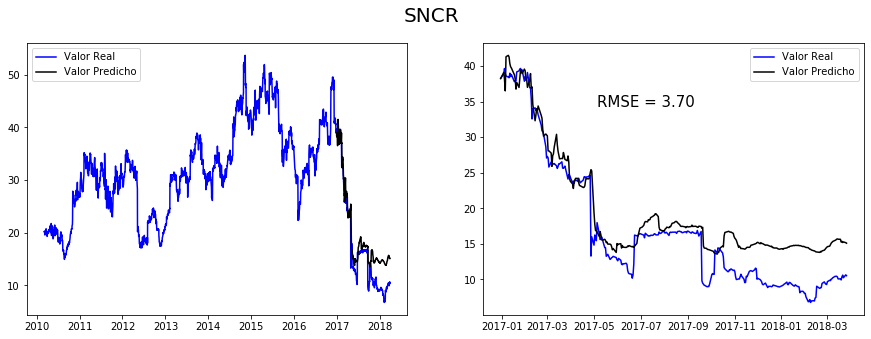

In [190]:
# Calculo la prediccion para mi conjunto test
predicted_stock_price = pd.DataFrame(model.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmse = sqrt(mean_squared_error(ytt, predicted_stock_price))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle(tickers[index],fontsize = 20)
# Plot de todo el grafico
ax1.plot(indicedetiempo,stock_real_value,label="Valor Real",color = "blue")
ax1.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax1.legend()

# Plot de solo la parte que hemos hecho el predict
ax2.plot(index_time_t,ytt,label="Valor Real",color = "blue")
ax2.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax2.legend()
ax2.annotate('RMSE = %.2f'% rmse, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Mido el RMSE con 1500 epocas en diferentes modelos, buscamos valores bajos


| Ticket | 8-4    | 4-2   | 2-2  | 4    | 
|--------|--------|-------|----- |------|
| SNCR   | 2.67   | 2.15  | 2.15 | 2.15 | 
| EBIO   | 0.14   | 0.15  | 0.13 | 0.12 |
| MINI   | 1.34   | 1.01  | 1.01 | 1.05 |
| JBMA   | 0.67   | 0.36  | 0.35 | 0.43 |
| PTIE   | 0.83   | 0.74  | 0.83 | 0.72 |

Mido el Porcentaje_margen con 1500 epocas en diferentes modelos, buscamos valores altos


| Ticket | 8-4    | 4-2   | 2-2  | 4    | 
|--------|--------|-------|----- |------|
| SNCR   | 0.82   | 0.81  | 0.80 | 0.79 | 
| EBIO   | 0.60   | 0.50  | 0.45 | 0.48 |
| MINI   | 0.90   | 0.89  | 0.88 | 0.86 |
| JBMA   | 0.87   | 0.84  | 0.81 | 0.81 |
| PTIE   | 0.75   | 0.71  | 0.71 | 0.61 |


PTIE no hace una prediccion tan buena como las otras y es de extendido


Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [186]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos

# Es un margen movil, segun lo que busquemos
margen = 0.05
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({0.0: 291, -1.0: 12, 1.0: 6})


In [191]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26     83790.2        0      0  10.65  15.1753   0
Valor Final = 83790.20
Ganancia con margen = -16209.80


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [192]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      383558        0         19197      0  10.65  15.1753   0
Valor Final = 179109.83
Ganancia con margen = 79109.83


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [189]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      449977        0         22521      0  10.65  15.1753   0
Valor Final = 210128.19
Ganancia con margen = 110128.19


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  